In [30]:
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from utils.generators import UserGenerator

In [3]:
ug = UserGenerator()

In [4]:
dat = ug.generate_lift_data(1000,0.1,0.5,1)

In [5]:
dat['hour'] = dat.datetime.dt.hour

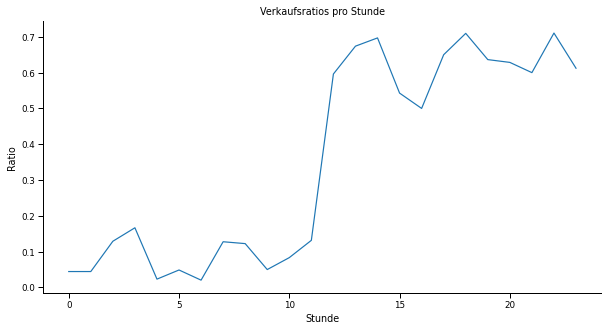

In [25]:
fig = plt.figure(figsize=(10,5))
sns.set_context("paper")
ax = sns.lineplot( data=dat.groupby('hour')['purchased'].mean() )
ax.set_title("Verkaufsratios pro Stunde")
ax.set(xlabel='Stunde', ylabel='Ratio')
sns.despine()

In [27]:
dat['purchased']

942    0
891    0
790    0
30     0
614    0
      ..
396    1
405    0
269    0
267    1
377    0
Name: purchased, Length: 1000, dtype: int64

In [37]:
with pm.Model() as model:
    
    lambda_1 = pm.Uniform("lambda_1",  lower=0, upper=1)
    lambda_2 = pm.Uniform("lambda_2",  lower=0, upper=1)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=dat.shape[0] - 1)
    
    # to be able to tell the index point of change we need to add an index
    index = np.arange(dat.shape[0])
    
    # a switch to find the point of interest
    lambda_ = pm.math.switch(tau > index, lambda_1, lambda_2)
    
    observation = pm.Binomial("obs", p=lambda_, n=dat.shape[0], observed=dat.purchased)
    #observation = pm.Poisson("obs", lambda_, observed=dat.purchased)
    
    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000,step=step)

INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5462.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [53]:
tau_post = trace['tau'][:5000]

lambda_1 = trace['lambda_1'][:5000] * dat.shape[0]
lambda_2 = trace['lambda_2'][:5000] * dat.shape[0]


[Text(0, 0.5, 'Relative Häufigkeit'), Text(0.5, 0, 'Index')]

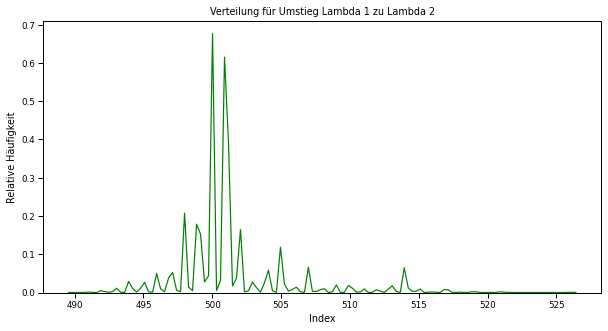

In [64]:
fig = plt.figure(figsize=(10,5))
ax = sns.distplot(tau_post,color='g', hist=False)
ax.set_title("Verteilung für Umstieg Lambda 1 zu Lambda 2")
ax.set(xlabel='Index', ylabel='Relative Häufigkeit')

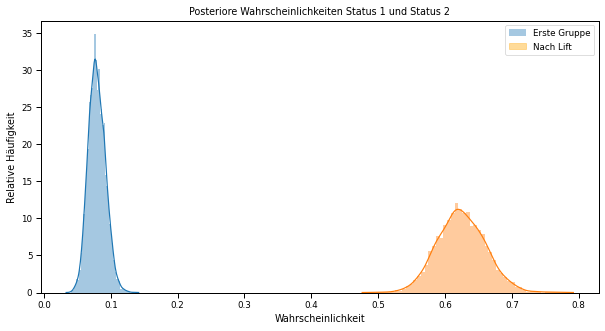

In [70]:

fig = plt.figure(figsize=(10,5))
ax = sns.distplot(lambda_1)
sns.distplot(lambda_2)
ax.set_title("Posteriore Wahrscheinlichkeiten Status 1 und Status 2")
ax.set(xlabel='Wahrscheinlichkeit', ylabel='Relative Häufigkeit')
legend = ax.legend(labels=["Erste Gruppe","Nach Lift"])
legend.legendHandles[1].set_color('orange')
